# Surface Mapping using Apriltags

In this notebook, we show how to use AprilTags to map from gaze-to screen coordinates. Along the way, we will also show some additional epoching functionalities.

To do so, we have collected a dataset where a participant freely views artworks presented on screen. Each artwork is shown for 4s, followed by a 0.5s inter trial intervall and a 0.5s central fixation cross. We can download this dataset using `get_sample_data()`.

In [1]:
import numpy as np

from pyneon import Recording, get_sample_data

# Load a sample recording
rec_dir = (
    get_sample_data("Artworks") / "Timeseries Data + Scene Video" / "artworks-9a141750"
)
rec = Recording(rec_dir)
print(rec)


Data format: cloud
Recording ID: 9a141750-95ca-48ee-9693-53bbb896b87e
Wearer ID: c4f68887-e96c-467f-a901-0fc9fce09c0a
Wearer name: JGH
Recording start time: 2025-06-16 12:49:27.817000
Recording duration: 357538000000 ns (357.538 s)



Let us take a closer look at the events file, populated with triggers sent during the initial viewing

In [2]:
event_data = rec.events.data
print(event_data.head(10))

               timestamp [ns]  \
event id                        
0         1750070967817000000   
1         1750070973028401000   
2         1750070973726906000   
3         1750070977877138000   
4         1750070978659847000   
5         1750070979391162000   
6         1750070983510925000   
7         1750070984367660000   
8         1750070985019038000   
9         1750070989241548000   

                                                       name       type  
event id                                                                
0                                           recording.begin  recording  
1                                            fixation onset  recording  
2          image onset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording  
3         image offset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording  
4                                            fixation onset  recording  
5          image onset 29a102da-4838-432b-7373-a3c7f5679d75  recording  
6         image off

We can see that the name column holds the information ofinterest to us. As the column ontains both information about the event_type as well as its name, we will first parse these apart. This process is a bit lengthy, but necessary to make sense of our data

In [3]:
# parse the name column, look for the key words image onset and image offset
def parse_event_name(name):
    if "image onset" in name.lower():
        type = "image onset"
        name = name.lower().replace("image onset ", "").strip()
    elif "image offset" in name.lower():
        type = "image offset"
        name = name.lower().replace("image offset ", "").strip()
    else:
        type = "other"
        name = None
    return type, name


for i, row in event_data.iterrows():
    type, name = parse_event_name(row["name"])
    event_data.at[i, "event_type"] = type
    event_data.at[i, "image_name"] = name

print(event_data.head(5))

               timestamp [ns]  \
event id                        
0         1750070967817000000   
1         1750070973028401000   
2         1750070973726906000   
3         1750070977877138000   
4         1750070978659847000   

                                                       name       type  \
event id                                                                 
0                                           recording.begin  recording   
1                                            fixation onset  recording   
2          image onset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording   
3         image offset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording   
4                                            fixation onset  recording   

            event_type                            image_name  
event id                                                      
0                other                                  None  
1                other                                  None

Resetting video...
Resetting video...
Resetting video...


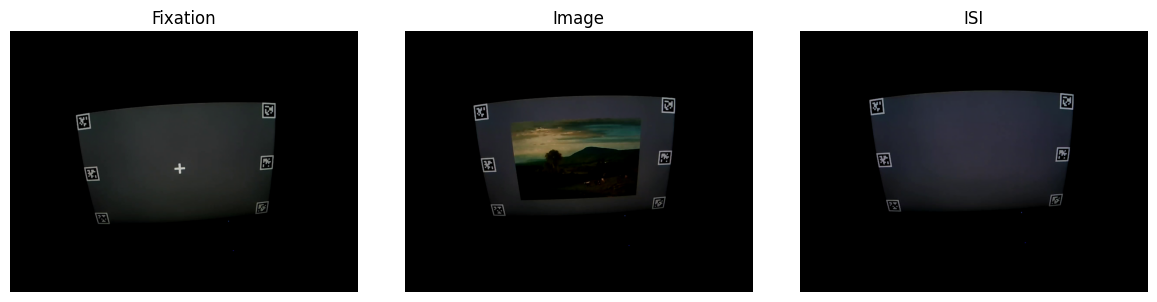

In [4]:
import matplotlib.pyplot as plt

video = rec.scene_video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(170, ax=axs[0], auto_title=False, show=False)
video.plot_frame(200, ax=axs[1], auto_title=False, show=False)
video.plot_frame(320, ax=axs[2], auto_title=False, show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.tight_layout()
plt.show()

In all of the frames shown above, we can see QR-code like markers at the borders of the screen. These are called apriltags and can be used as fiducial markers to relate video to real-world coordinates. PyNeon wraps a function that performs the detection of these. For computational efficiency, we only perform one detection every 30 frames.

In [5]:
all_detections = video.detect_markers(
    detection_window=(0, 100), detection_window_unit="frame"
)
print(all_detections.data.head())

Detecting markers (sequential): 100%|██████████| 101/101 [00:01<00:00, 69.43it/s]

                     frame id   tag id  corner 0 x [px]  corner 0 y [px]  \
timestamp [ns]                                                             
1750070970452166666        53  36h11_3           1132.0            384.0   
1750070970452166666        53  36h11_0            268.0            421.0   
1750070970452166666        53  36h11_5           1090.0            831.0   
1750070970452166666        53  36h11_4           1115.0            626.0   
1750070970452166666        53  36h11_1            306.0            661.0   

                     corner 1 x [px]  corner 1 y [px]  corner 2 x [px]  \
timestamp [ns]                                                           
1750070970452166666           1081.0            381.0           1081.0   
1750070970452166666            223.0            429.0            218.0   
1750070970452166666           1046.0            836.0           1052.0   
1750070970452166666           1067.0            627.0           1071.0   
1750070970452166666    

Having detected the apriltags, we now need to provide information on the real-world coordinates of our apriltags. This is solved via a tag_info dataframe, which we generate below.

In [6]:
import pandas as pd


def generate_tag_info(win_size, tag_ids=None, tag_size=200):
    """
    Generate marker information for a given window size.

    Args:
        win_size (tuple): The width and height of the window.
        tag_ids (list, optional): List of tag IDs. Defaults to [0, 1, 2, 3, 4, 5].
        tag_size (int, optional): Size of the tags. Defaults to 200.

    Returns:
        pd.DataFrame: A DataFrame containing marker IDs and their corner positions.
    """
    if tag_ids is None:
        tag_ids = [0, 1, 2, 3, 4, 5]  # Default tag IDs

    win_half_width, win_half_height = np.array(win_size) / 2
    half_tag_size = tag_size / 2

    positions = [
        (-win_half_width + half_tag_size, win_half_height - half_tag_size),  # top-left
        (-win_half_width + half_tag_size, 0),  # middle-left
        (
            -win_half_width + half_tag_size,
            -win_half_height + half_tag_size,
        ),  # bottom-left
        (win_half_width - half_tag_size, win_half_height - half_tag_size),  # top-right
        (win_half_width - half_tag_size, 0),  # middle-right
        (
            win_half_width - half_tag_size,
            -win_half_height + half_tag_size,
        ),  # bottom-right
    ]

    marker_corners = []
    for pos in positions:
        cx, cy = pos
        corners = [
            [cx - half_tag_size, cy + half_tag_size],  # top-left
            [cx + half_tag_size, cy + half_tag_size],  # top-right
            [cx + half_tag_size, cy - half_tag_size],  # bottom-right
            [cx - half_tag_size, cy - half_tag_size],  # bottom-left
        ]
        marker_corners.append(corners)

    tag_info = pd.DataFrame({"marker_id": tag_ids, "marker_corners": marker_corners})

    return tag_info


tag_info = generate_tag_info((1920, 1080))

In [7]:
print(tag_info)

   marker_id                                     marker_corners
0          0  [[-960.0, 540.0], [-760.0, 540.0], [-760.0, 34...
1          1  [[-960.0, 100.0], [-760.0, 100.0], [-760.0, -1...
2          2  [[-960.0, -340.0], [-760.0, -340.0], [-760.0, ...
3          3  [[760.0, 540.0], [960.0, 540.0], [960.0, 340.0...
4          4  [[760.0, 100.0], [960.0, 100.0], [960.0, -100....
5          5  [[760.0, -340.0], [960.0, -340.0], [960.0, -54...


With this, we can now run the ``find_homograpghy()`` method. This method finds the map between the detections and the provided coordinates for each frame. As we did not do detections in every frame, we further provide the skip_frames as used before so that the homographies can be interpolated.

In [8]:
# cast index to np.ndarray
index = rec.gaze.data.index.to_numpy()
print(index[:10])

[1750070970217815359 1750070970222935359 1750070970227935359
 1750070970232948359 1750070970237935359 1750070970242942359
 1750070970247935359 1750070970252935359 1750070970257945359
 1750070970262941359]


In [9]:
homographies = rec.find_homographies(
    tag_info=tag_info,
    all_detections=all_detections,
    skip_frames=30,
    upsample_to="gaze",
    overwrite=True,
    max_gap=1,
)

Computing homographies for frames: 100%|██████████| 45/45 [00:00<00:00, 850.68it/s]


TypeCheckError: value of key np.int64(53) of argument "homographies_dict" (dict) is not an instance of numpy.ndarray

with this, we can finally transform both gaze and fixation coordinates into the screen's reference frame:

In [ ]:
gaze_on_screen = rec.gaze_on_surface(homographies=homographies, overwrite=True)
fixations_on_screen = rec.fixations_on_surface(
    gaze_on_surface=gaze_on_screen, overwrite=True
)

C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\tabular.py:66: UserWarning: Following columns not in known data types, using default data types: fixation x [surface coord], fixation y [surface coord]
  warn(


In [ ]:
gaze_data = gaze_on_screen.data
fix_data = fixations_on_screen.data

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    gaze_data["gaze x [surface coord]"],
    gaze_data["gaze y [surface coord]"],
    s=1,
    alpha=0.5,
    c=gaze_data.index,
    cmap="viridis",
)

plt.scatter(
    fix_data["fixation x [surface coord]"],
    fix_data["fixation y [surface coord]"],
    s=1,
    c="black",
    label="Fixations",
)

plt.plot(
    [-600, 600, 600, -600, -600],
    [-400, -400, 400, 400, -400],
    color="red",
    label="Image outline",
)

plt.xlabel("X Coordinate (surface coord)")
plt.ylabel("Y Coordinate (surface coord)")

plt.xlim(-800, 800)
plt.ylim(-600, 600)

(-600.0, 600.0)